In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# NumPy beyond 2020

Ross Barnowski `rossbar@berkeley.edu` | [rossbar](https://github.com/rossbar) on GitHub

University of Michigan EECS | 1/30/2020

# What is NumPy?

> *NumPy is the fundamental package for scientific computing with Python*
> 
>  [numpy.org](https://numpy.org/)

Strong stuff.

In [2]:
# Code example: github graphql query for top starred projects with numpy as a dependency

# A bit of history

 - **Mid 90's/Early 00's**: desire for high-performance numerical computation in python leads to [`numeric`](https://numpy.org/_downloads/768fa66c250a0335ad3a6a30fae48e34/numeric-manual.pdf)
 - Early adopters included the [Space Telescope Science Institute (STScI)](http://www.stsci.edu/) who developed another array computation package to better suit their needs: `numarray`.
 - **2005** The best ideas from `numeric` and `numarray` were combined in the development of a new library, `numpy`
   * This work was largely done by Travis Oliphant, a graduate student at the Mayo Clinic at the time
 - **2006** Numpy v1.0 released
 
[NumPy Development History](https://github.com/numpy/numpy/graphs/contributors)

# What does NumPy provide?

 - `ndarray`: A generic, n-dimensional array data structure
 - Sophisticated machinery for operating on array data (broadcasting, `ufuncs`)
 - Tools for common scientific/numerical tasks:
   * Random number generation (`np.random`)
   * Fourier analysis (`np.fft`)
   * Linear algebra (`np.linalg`)
 - Language extension/integration (C-API, `f2py`)

# Where is NumPy used?

 - To produce the first image of a black hole 
   [Event Horizon Telescope Collaboration](https://github.com/achael/eht-imaging)
 - [To detect the gravitational wave signature from a neutron star merger](https://github.com/gwastro/pycbc)
 - [To discover fundamental particles like the Higgs Boson](https://github.com/cms-sw/cmssw)
   * Also [scikit-hep](https://scikit-hep.org/)
 - [Neuroimaging](https://nipy.org/nibabel/) - nipy uses `ndarray` as the fundamental structure for the entire stack
   * fMRI visualization example from [section 3.4](https://www.frontiersin.org/articles/10.3389/fninf.2014.00014/full#h4)
     is a nice, brief example

# Scope of NumPy

NumPy currently targets computation involving:

 * in-memory, homogenously-typed array data
 * cpu-based
 
Important guiding principles:
 - **Stability**: Foundational component of the scientific python ecosystem for going-on 15 years
 - **Interoperability**: A *de facto* standard for array APIs in python

# Adapting to community needs

 - In the early days, many new NumPy users were converts from matlab
   * See the [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html) article in the docs
   
 - Now: The scientific ecosystem is incredibly feature-rich and powerful: attracting many new users
   * Users interested in specific applications (geoscience, image segmentation, bioinformatics, etc.) end up interacting with NumPy indirectly
   * Focus resources on supporting stable, performant base for dependent libraries
     * Why scope is important: what is worth the maintenance burden
     * Balance between performance and maintainability
     > Optimization is the altar where maintainability is sacrificed
     >
     > L. Ramalho, *Fluent Python*

## Google Trends

<IPython.core.display.Javascript object>


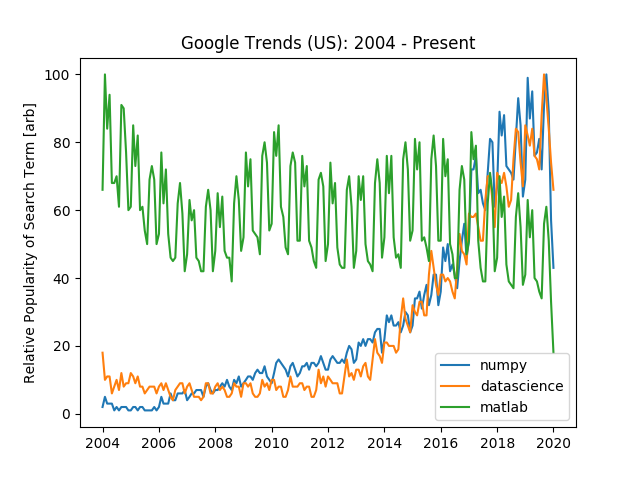

In [6]:
timeseries_dtype = np.dtype([
    ('date', 'datetime64[M]'),
    ('relpop', float)
])

parse_kwargs = {
    "skiprows" : 3,
    "delimiter" : ",",
    "dtype" : timeseries_dtype
}

gtrends_search_terms = ("NumPy", "Data Science", "Matlab")
fnames = [name.lower().replace(' ', '') for name in gtrends_search_terms]

data = {
    fname : np.loadtxt("data/{}.csv".format(fname), **parse_kwargs) for fname in fnames
}

fig, ax = plt.subplots()
for name, vals in data.items():
    plt.plot(vals['date'], vals['relpop'], label=name)
ax.set_title('Google Trends (US): 2004 - Present')
ax.set_ylabel('Relative Popularity of Search Term [arb]')
ax.legend();

<IPython.core.display.Javascript object>


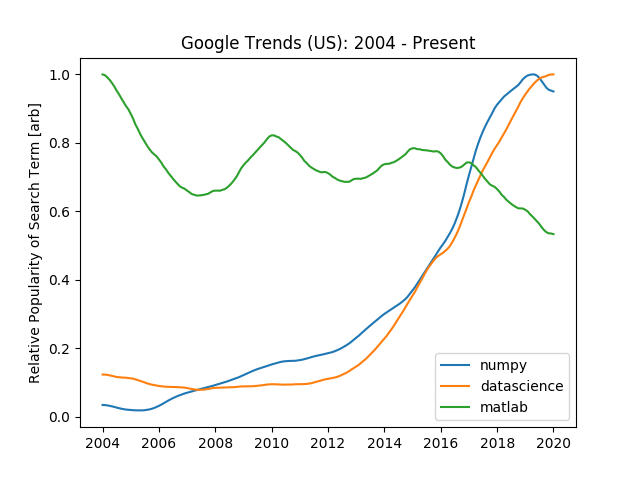

In [5]:
def smooth(s, kernsize=21):
    s_padded = np.r_[s[kernsize-1:0:-1], s, s[-2:-kernsize-1:-1]]
    kern = np.hamming(kernsize)
    res_padded = np.convolve(kern/kern.sum(), s_padded, mode='valid')
    # De-pad and renormalize
    return res_padded[kernsize//2:-kernsize//2+1] / res_padded.max()

fig, ax = plt.subplots()
for name, vals in data.items():
    plt.plot(vals['date'], smooth(vals['relpop']), label=name)
ax.set_title('Google Trends (US): 2004 - Present')
ax.set_ylabel('Relative Popularity of Search Term [arb]')
ax.legend();

# How is NumPy Developed

 - Collaboratively (caveat here about the bus factor)

Commitment to stability means proposed changes must go through extensive design and review:
 - NEPs - analogous to PEPs, specific to NumPy
 - Steering council for high-level direction and coordination with [NumFOCUS](https://numfocus.org/)

# Case-Study: `np.random`

 - Overhaul of `np.random` landed in version 1.17
 
   * Improve *performance* and *flexibility* without sacrificing stability

In [11]:
# Generate 1,000,000 random numbers the old way
old_rands = np.random.random(int(1e6))
print("Uniform random numbers from np.random.random:\n  {}".format(old_rands))

# ... and the new way
from numpy.random import PCG64, Generator
rg = Generator(PCG64())
new_rands = rg.random(int(1e6))
print("Uniform random numbers using new tools:\n  {}".format(new_rands))

Uniform random numbers from np.random.random:
  [0.8225427  0.68455216 0.39735121 ... 0.74763099 0.70349033 0.20668629]
Uniform random numbers using new tools:
  [0.71342172 0.17574351 0.00564204 ... 0.8464664  0.4389198  0.50679909]


## Compatibility

Before version 1.17, `numpy.random` relied on `RandomState` to configure and produce random numbers.

There are many, many LOCs (both in test suites and in production) that depend on the original `numpy.random`, so both the *interface* and the *implementation* must remain unchanged
 * <font color="green">**Upside:**</font> output of `np.random` remains "stable"
 * <font color="orange">**Downside:**</font> users must learn a new interface to access improvements

In [12]:
# Choose a seed for generator
seed = 1817

# Random numbers generated by np.random in v1.15
rands_from_v1_15 = np.load('data/npy_v1.15_random_seed1817_1000samples.npy')
# Generate random numbers with legacy interface
np.random.seed(seed)
legacy_rands = np.random.random(1000)

print("Arrays equivalent: ", np.allclose(rands_from_v1_15, legacy_rands))

Arrays equivalent:  True


In [ ]:
# comparison of random here | include timeit examples | parallel example too?

# What's next?

 - Borrow heavily from [Ralf's talk](https://www.slideshare.net/RalfGommers/pydata-nyc-whatsnew-numpyscipy-2019)

# Getting involved

Great opportunity to work on a project that is depended on by tens of millions of users (and counting)

What can you do:

 1. Contribute
 
   - [GitHub Issues](https://github.com/numpy/numpy/issues) and [open PRs](https://github.com/numpy/numpy/pulls) are a great entry point
     * If you want to get your hands dirty immediately, try starting with the [good first issue](https://github.com/numpy/numpy/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22) label
     * For challenges with a greater scope, try the [Enhancement](https://github.com/numpy/numpy/labels/01%20-%20Enhancement) or [Wish List](https://github.com/numpy/numpy/labels/23%20-%20Wish%20List) labels
   - Check out the discussion revolving around current and future [NEPs](https://numpy.org/neps/)
   

 2. Participate in the conversation
 
  - [Numpy discussion mailing list](https://www.scipy.org/scipylib/mailing-lists.html)
  - Numpy community meetings (links and cadence here)
  - slack channel